# <center> Testando o Custom Variable Type do Pymoo </center>

### Bibliotecas

In [6]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.sampling import Sampling
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation
from pymoo.core.duplicate import ElementwiseDuplicateElimination


### Definindo o Problema

In [7]:


class MyProblem(ElementwiseProblem):

    def __init__(self, n_characters=10):
        super().__init__(n_var=1, n_obj=2, n_ieq_constr=0)
        self.n_characters = n_characters
        self.ALPHABET = [c for c in string.ascii_lowercase]

    def _evaluate(self, x, out, *args, **kwargs):
        n_a, n_b = 0, 0
        for c in x[0]:
            if c == 'a':
                n_a += 1
            elif c == 'b':
                n_b += 1

        out["F"] = np.array([- n_a, - n_b], dtype=float)

### Sampling

In [8]:

class MySampling(Sampling):

    def _do(self, problem, n_samples, **kwargs):
        X = np.full((n_samples, 1), None, dtype=object)

        for i in range(n_samples):
            X[i, 0] = "".join([np.random.choice(problem.ALPHABET) for _ in range(problem.n_characters)])

        return X


### Crossover

In [9]:

class MyCrossover(Crossover):
    def __init__(self):

        # define the crossover: number of parents and number of offsprings
        super().__init__(2, 2)

    def _do(self, problem, X, **kwargs):

        # The input of has the following shape (n_parents, n_matings, n_var)
        _, n_matings, n_var = X.shape

        # The output owith the shape (n_offsprings, n_matings, n_var)
        # Because there the number of parents and offsprings are equal it keeps the shape of X
        Y = np.full_like(X, None, dtype=object)

        # for each mating provided
        for k in range(n_matings):

            # get the first and the second parent
            a, b = X[0, k, 0], X[1, k, 0]

            # prepare the offsprings
            off_a = ["_"] * problem.n_characters
            off_b = ["_"] * problem.n_characters

            for i in range(problem.n_characters):
                if np.random.random() < 0.5:
                    off_a[i] = a[i]
                    off_b[i] = b[i]
                else:
                    off_a[i] = b[i]
                    off_b[i] = a[i]

            # join the character list and set the output
            Y[0, k, 0], Y[1, k, 0] = "".join(off_a), "".join(off_b)

        return Y

### Mutation

In [10]:

class MyMutation(Mutation):
    def __init__(self):
        super().__init__()

    def _do(self, problem, X, **kwargs):

        # for each individual
        for i in range(len(X)):

            r = np.random.random()

            # with a probabilty of 40% - change the order of characters
            if r < 0.4:
                perm = np.random.permutation(problem.n_characters)
                X[i, 0] = "".join(np.array([e for e in X[i, 0]])[perm])

            # also with a probabilty of 40% - change a character randomly
            elif r < 0.8:
                prob = 1 / problem.n_characters
                mut = [c if np.random.random() > prob
                       else np.random.choice(problem.ALPHABET) for c in X[i, 0]]
                X[i, 0] = "".join(mut)

        return X

### Duplicates

In [11]:


class MyDuplicateElimination(ElementwiseDuplicateElimination):

    def is_equal(self, a, b):
        return a.X[0] == b.X[0]

### Optimize

In [12]:
import string
import numpy as np

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize


algorithm = NSGA2(pop_size=11,
                  sampling=MySampling(),
                  crossover=MyCrossover(),
                  mutation=MyMutation(),
                  eliminate_duplicates=MyDuplicateElimination())

res = minimize(MyProblem(),
               algorithm,
               ('n_gen', 100),
               seed=1,
               verbose=False)


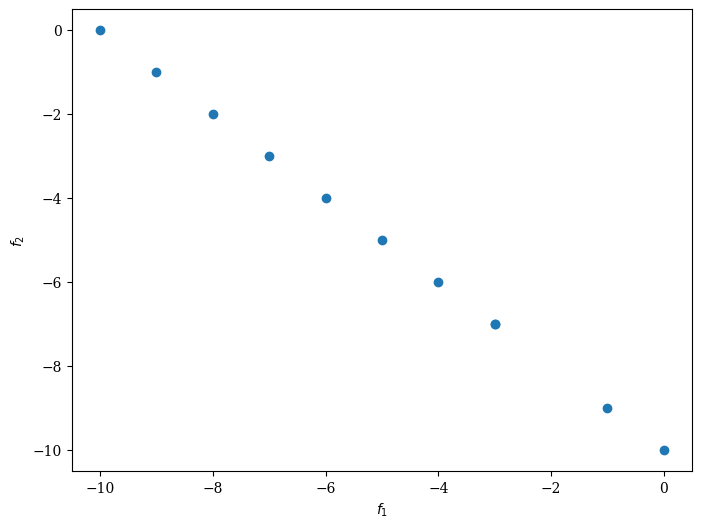

In [13]:
from pymoo.visualization.scatter import Scatter
Scatter().add(res.F).show()